In [136]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
from matplotlib.animation import FuncAnimation

In [148]:
##FINAL VERSION

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position.copy()

    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        #print(self.best_position)
        self.position += self.velocity
        #print(self.best_position)
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

    def update_best_position(self, objective_function):
        if objective_function(self.position) < objective_function(self.best_position):
            self.best_position = self.position.copy()

class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.particles = []
        self.global_best_position = None
        self.particle_positions_history = []
        self.particle_fitness_history = []

    def optimize(self, objective_function, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            print('Iter', iter)
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([objective_function(particle.position) for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position(objective_function)

            self.update_global_best_position(objective_function)

    def initialize_particles(self):
        self.particles = []
        for _ in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds)
            velocity = np.zeros_like(position)
            particle = Particle(position, velocity)
            self.particles.append(particle)

        self.global_best_position = self.particles[np.argmin([objective_function(particle.position) for particle in self.particles])].position.copy()
        print('BEst initial position:', self.global_best_position)
        print('BEst initial cost:', objective_function( self.global_best_position))

    def update_global_best_position(self, objective_function):
        counter = 0
        for particle in self.particles:
            if objective_function(particle.position) < objective_function(self.global_best_position):
                #print(particle.position)
                #print(self.global_best_position)

                #print('Global best value before update', objective_function(self.global_best_position))
                #print('Global best position before update', self.global_best_position)
                self.global_best_position = particle.position.copy()
                #print('Global best value after update',  objective_function(self.global_best_position))
                #print('Global best position after update', self.global_best_position)
                counter += 1
        print(counter)


    def plot_particle_positions(self, frame):
        plt.cla()
        plt.plot(*zip(*self.particle_positions_history[frame]), 'go', markersize=6)
        plt.contourf(self.X, self.Y, self.Z, levels=np.linspace(0, 100, 50), cmap='viridis')
        plt.xlabel('x')
        plt.ylabel('y')

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()
    def plot_particle_history(self):
        self.particle_positions_history = np.array(self.particle_positions_history)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        # Plot histogram at the start
        ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_positions_history) // 2
        ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()


# Example usage
pso = PSO(num_particles=100, max_iterations=1000, lower_bounds=[-10, -10], upper_bounds=[10, 10])

def objective_function(x):
    return float(x[0]**2 + x[1]**2)

pso.optimize(objective_function)
pso.plot_particle_history()
pso.plot_particle_fitness_history()



BEst initial position: [0.15234973 0.514665  ]
BEst initial cost: 0.2880904996122699
Iter 0
0
Iter 1
2
Iter 2
2
Iter 3
0
Iter 4
0
Iter 5
2
Iter 6
1
Iter 7
2
Iter 8
1
Iter 9
0
Iter 10
0
Iter 11
1
Iter 12
2
Iter 13
1
Iter 14
1
Iter 15
1
Iter 16
1
Iter 17
0
Iter 18
0
Iter 19
2
Iter 20
0
Iter 21
0
Iter 22
0
Iter 23
0
Iter 24
1
Iter 25
0
Iter 26
1
Iter 27
1
Iter 28
1
Iter 29
1
Iter 30
0
Iter 31
0
Iter 32
1
Iter 33
1
Iter 34
0
Iter 35
1
Iter 36
1
Iter 37
1
Iter 38
1
Iter 39
1
Iter 40
1
Iter 41
0
Iter 42
1
Iter 43
1
Iter 44
1
Iter 45
1
Iter 46
0
Iter 47
1
Iter 48
1
Iter 49
1
Iter 50
2
Iter 51
0
Iter 52
0
Iter 53
3
Iter 54
2
Iter 55
0
Iter 56
0
Iter 57
0
Iter 58
0
Iter 59
0
Iter 60
1
Iter 61
0
Iter 62
0
Iter 63
1
Iter 64
1
Iter 65
0
Iter 66
0
Iter 67
2
Iter 68
1
Iter 69
0
Iter 70
0
Iter 71
1
Iter 72
1
Iter 73
1
Iter 74
0
Iter 75
1
Iter 76
1
Iter 77
0
Iter 78
0
Iter 79
0
Iter 80
0
Iter 81
1
Iter 82
1
Iter 83
1
Iter 84
1
Iter 85
0
Iter 86
0
Iter 87
0
Iter 88
1
Iter 89
1
Iter 90
0
Iter 91
0
Iter 

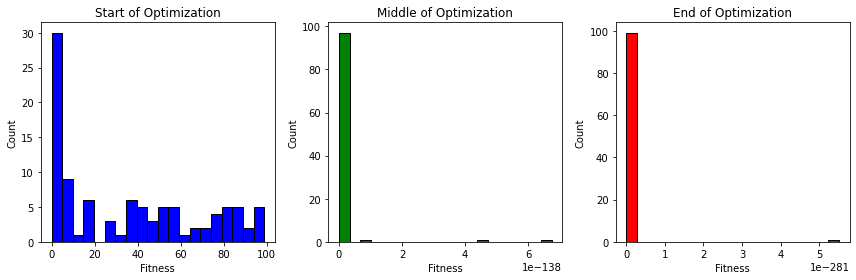

TypeError: plot_particle_positions() missing 1 required positional argument: 'frame'

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position

    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

    def update_best_position(self, objective_function):
        if objective_function(self.position) < objective_function(self.best_position):
            self.best_position = self.position


class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.particle_positions_history = []
        self.particle_fitness_history = []

    def optimize(self, objective_function, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for _ in range(self.max_iterations):
            self.particle_positions_history.append([particle.position for particle in self.particles])
            self.particle_fitness_history.append([objective_function(particle.position) for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position(objective_function)

            self.update_global_best_position(objective_function)

    def initialize_particles(self):
        self.particles = []
        for _ in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            particle = Particle(position, velocity)
            self.particles.append(particle)

        self.global_best_position = self.particles[np.argmin([objective_function(particle.position) for particle in self.particles])].position

    def update_global_best_position(self, objective_function):
        for particle in self.particles:
            if objective_function(particle.position) < objective_function(self.global_best_position):
                self.global_best_position = particle.position

    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()

    def plot_particle_positions_animate(self):
        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()


# Example usage
pso = PSO(num_particles=100, max_iterations=1000, lower_bounds=-10, upper_bounds=10, dimension=1)

def objective_function(x):
    return float(x**2)

def objective_function_2d(x):
    return float(x[0]**2 + x[1]**2)

pso.optimize(objective_function)
#pso.plot_particle_positions_animate()
pso.plot_particle_fitness_history()
pso.plot_particle_()

In [19]:
len(pso.particle_fitness_history[0])

100

In [23]:
pso2 = PSO(num_particles=100, max_iterations=1000, lower_bounds=-10, upper_bounds=10, dimension=2)

def objective_function(x):
    return x**2

def objective_function_2d(x):
    return x[0]**2 + x[1]**2

pso2.optimize(objective_function_2d)
#pso.plot_particle_positions_animate()
#pso.plot_particle_fitness_history()
pso2.particle_fitness_history

[[4.257159716076136,
  53.87472165186009,
  76.15484573519458,
  15.454018572427575,
  46.891205633912556,
  67.72695017660406,
  90.34505510471125,
  102.42873035695953,
  194.89049740776323,
  67.69859334070411,
  66.7713486800379,
  16.41318363591054,
  21.021164988216526,
  17.001025571227636,
  17.22242920625222,
  70.15240208782099,
  3.3270698004840655,
  57.66499522197192,
  58.14311324857171,
  95.45750952075203,
  69.25160335292787,
  26.115467926535615,
  31.947291956905232,
  36.17835994142354,
  61.09295833331188,
  99.10470234867154,
  81.70924710770659,
  49.28468502790733,
  30.827201365431883,
  50.60372956607422,
  139.36091330319664,
  126.88493881653244,
  1.337074202141908,
  44.442824037525405,
  147.9298979774344,
  69.95996221176699,
  108.06498632142625,
  94.16353353339608,
  134.5272520619002,
  7.192829296969848,
  170.51794462797358,
  38.04328348874683,
  99.7559094506243,
  5.870175545046466,
  47.48698082086855,
  144.3496846266448,
  6.553194125334334,


In [ ]:
# 1 particle contains the values of T_peak and T_front
class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position # position =  parameters we want to infer
        
        self.position_cost_value = self.compute_fitness_function(self.position_cost_value)
        self.best_position_cost_value = self.compute_fitness_function(self.best_position)

    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position
            self.best_position_cost_value = self.position_cost_value

    def objective_function(self, position):
        return float(position[0]**2 + position[1]**2)




class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.particles = []
        self.global_best_position = None
        self.particle_positions_history = []
        self.particle_fitness_history = []

    def optimize(self, objective_function, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for _ in range(self.max_iterations):
            
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([objective_function(particle.position) for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position(objective_function)

            self.update_global_best_position(objective_function)

    def initialize_particles(self):
        self.particles = []
        for _ in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds)
            velocity = np.zeros_like(position)
            particle = Particle(position, velocity)
            self.particles.append(particle)

        self.global_best_position = self.particles[np.argmin([objective_function(particle.position) for particle in self.particles])].position

    def update_global_best_position(self, objective_function):
        for particle in self.particles:
            if objective_function(particle.position) < objective_function(self.global_best_position):
                self.global_best_position = particle.position

    def plot_particle_positions(self, frame):
        plt.cla()
        plt.plot(*zip(*self.particle_positions_history[frame]), 'go', markersize=6)
        plt.contourf(self.X, self.Y, self.Z, levels=np.linspace(0, 100, 50), cmap='viridis')
        plt.xlabel('x')
        plt.ylabel('y')

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()
    def plot_particle_history(self):
        self.particle_positions_history = np.array(self.particle_positions_history)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        # Plot histogram at the start
        ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_positions_history) // 2
        ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()


# Example usage
pso = PSO(num_particles=100, max_iterations=1000, lower_bounds=[-10, -10], upper_bounds=[10, 10])



pso.optimize(objective_function)
pso.plot_particle_history()
pso.plot_particle_fitness_history()
#pso.plot_particle_positions_history()
